<font size="+3">Solution on Clustering</font>

BAS 474

Charles Liu

One key concern of business analytics practitioners is to ensure that the right products are being sold to the right customers at the right price and at the right time.

In [1]:
load("KROGER.RData")

The `KROGER` dataframe in the global environment (after loading in the .RData file) contains the spending habits of 2000 customers at Kroger over the span of two years (this is why Kroger has a loyalty card; so it can track purchases over time!).
Specifically, it gives the *total amount of money each customer has spent on 13 broad categories of items* (alcohol, baby, meat, etc.).
Kroger would like to do some segmentation and cluster analysis to discover if there are "customer types"?
For example:

* House-spouses that takes care of both the cooking and grocery shopping?

* College students who buys cheap food and drinks that require minimal preparation?

* Parents of newborns?

* Casual shoppers buying products here and there?

* Health-conscious shoppers?

* Extreme couponers?

The segments above may indeed exist, and if so, Kroger could fine-tune marketing and advertising campaigns to meet the needs of each group.
This is a much more effective strategy than using a single campaign designed for everyone.
However, we need to let the data suggest what clusters exist in the data instead of inventing nice-sounding groups of our own.

# 1. Raw data

Include a histogram of the values in the `COOKING` column (butter, flour, etc.).  Look at (but do not include) the histograms of a few other columns.
By either using `apply` or `sapply` or by writing a `for` loop, print to the screen the `max` of each column, and print to the screen the `min` of each column.
There are reasons that designing a clustering scheme based on these recorded values is a bad idea.
Identify them (although you do not need to explain here WHY these two issues might potentially "mess up" the clustering scheme here since that's covered in the second part of this homework).

ALCOHOL      BABY   COOKING    DRINKS  FRUITVEG     GRAIN    HEALTH HOUSEHOLD 
 13916.99  10809.07  18235.77  27921.89   8186.33   2834.14   5931.18  14535.21 
     MEAT     OTHER       PET  PREPARED    SNACKS 
  8140.80  14648.01  11825.64   7141.00   8081.02

ALCOHOL      BABY   COOKING    DRINKS  FRUITVEG     GRAIN    HEALTH HOUSEHOLD 
        0         0         0         0         0         0         0         0 
     MEAT     OTHER       PET  PREPARED    SNACKS 
        0         0         0         0         0

ALCOHOL      BABY   COOKING    DRINKS  FRUITVEG     GRAIN    HEALTH HOUSEHOLD 
 13916.99  10809.07  18235.77  27921.89   8186.33   2834.14   5931.18  14535.21 
     MEAT     OTHER       PET  PREPARED    SNACKS 
  8140.80  14648.01  11825.64   7141.00   8081.02

ALCOHOL      BABY   COOKING    DRINKS  FRUITVEG     GRAIN    HEALTH HOUSEHOLD 
        0         0         0         0         0         0         0         0 
     MEAT     OTHER       PET  PREPARED    SNACKS 
        0         0         0         0         0

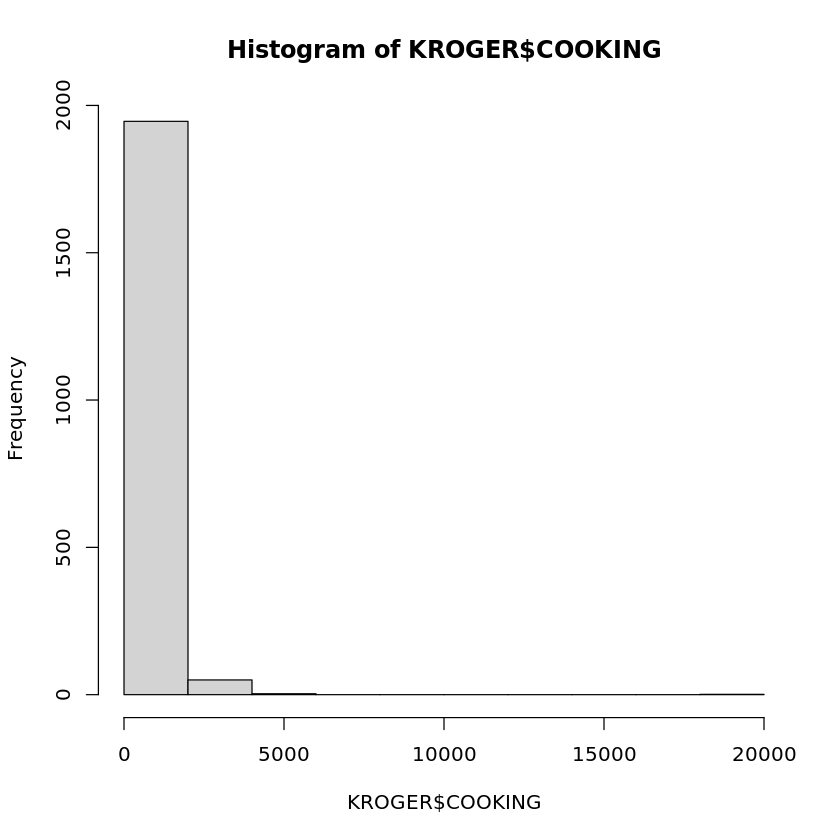

In [2]:
hist(KROGER$COOKING)

apply(KROGER, 2, max)
apply(KROGER, 2, min)

sapply(KROGER, max)
sapply(KROGER, min)

**Response:**

* The distributions of each variable is extremely skewed. Individuals with outlying values of a variable can end up in a cluster all by themselves (if their value is unique enough). Variables with a skew tend to carry more weight in the clustering scheme that variables with a symmetric. We want each individual and variable to have roughly equal say as to what the clusters look like!
* The data values aren’t scaled. Variables that have the most variation in its values (e.g., DRINKS) would dominate the distance measure, so we also need to scale the data.

**Grading:**

* 0.5 for having histogram of COOKING, 0.5 for output of max and min; 1 for at least one of the two reasons.
* They only need to name the reasons (skewness and not scaled) without going into detail (that’s covered in a later problem).

# 2. Scale data

In the global environment you will find a function called `scale_dataframe` which takes a dataframe as an argument.  It outputs the dataframe with each numerical quantity scaled to have a mean of 0 and a standard deviation of 1.   Left-arrow the result of running  `scale_dataframe( log10(KROGER+0.01) )` into `KROGER.SCALED` (this will add a penny to each value in `KROGER`, then take the log10 of each value, then scale each column to have a mean of 0 and a standard deviation of 1).  Run `apply(KROGER.SCALED,2,mean)` and `apply(KROGER.SCALED,2,sd)` to verify that each column has been transformed and scaled.

Provide a histogram of `COOKING` as well as a "kernel density estimate" (a smooth, continuous version of a histogram) of the distribution of `COOKING` with `plot(density(KROGER.SCALED$COOKING),xlim=c(-3,3),ylim=c(0,0.6),main="Kernel Density of Scaled Cooking")` to convince yourself that it is now more appropriate to do clustering.

Comment on why it was necessary to add 0.01 before taking the log10.

ALCOHOL          BABY       COOKING        DRINKS      FRUITVEG 
-5.752048e-17 -1.888572e-18  1.848721e-16 -2.786248e-16 -1.496886e-16 
        GRAIN        HEALTH     HOUSEHOLD          MEAT         OTHER 
 1.211686e-16  6.658647e-17 -2.197548e-17 -1.327681e-16 -8.906829e-17 
          PET      PREPARED        SNACKS 
 2.656859e-17  3.080781e-16 -1.807525e-16

ALCOHOL      BABY   COOKING    DRINKS  FRUITVEG     GRAIN    HEALTH HOUSEHOLD 
        1         1         1         1         1         1         1         1 
     MEAT     OTHER       PET  PREPARED    SNACKS 
        1         1         1         1         1

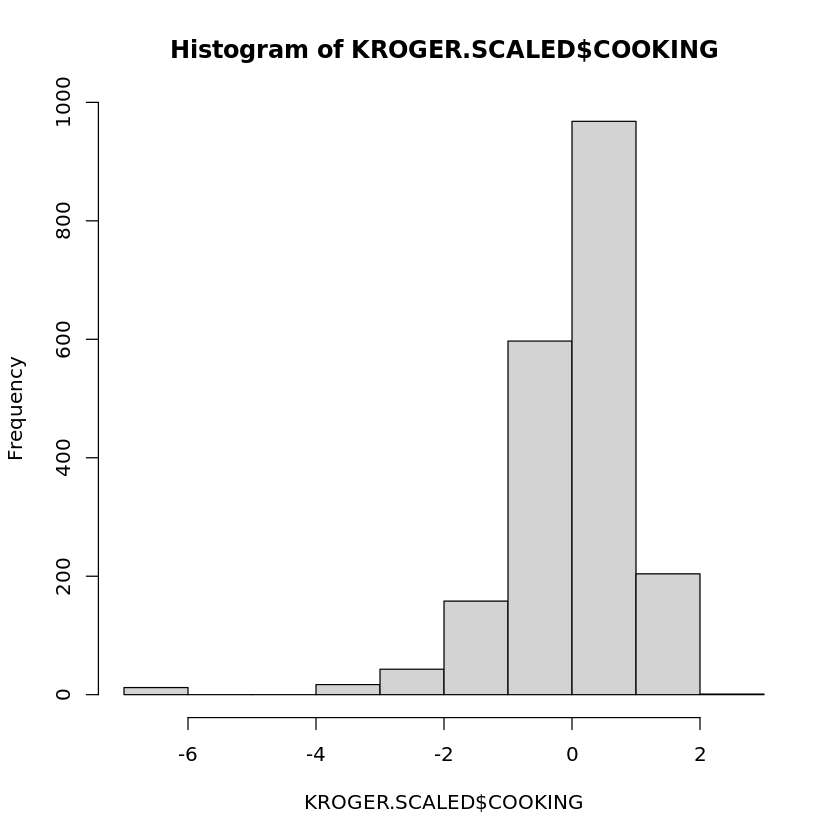

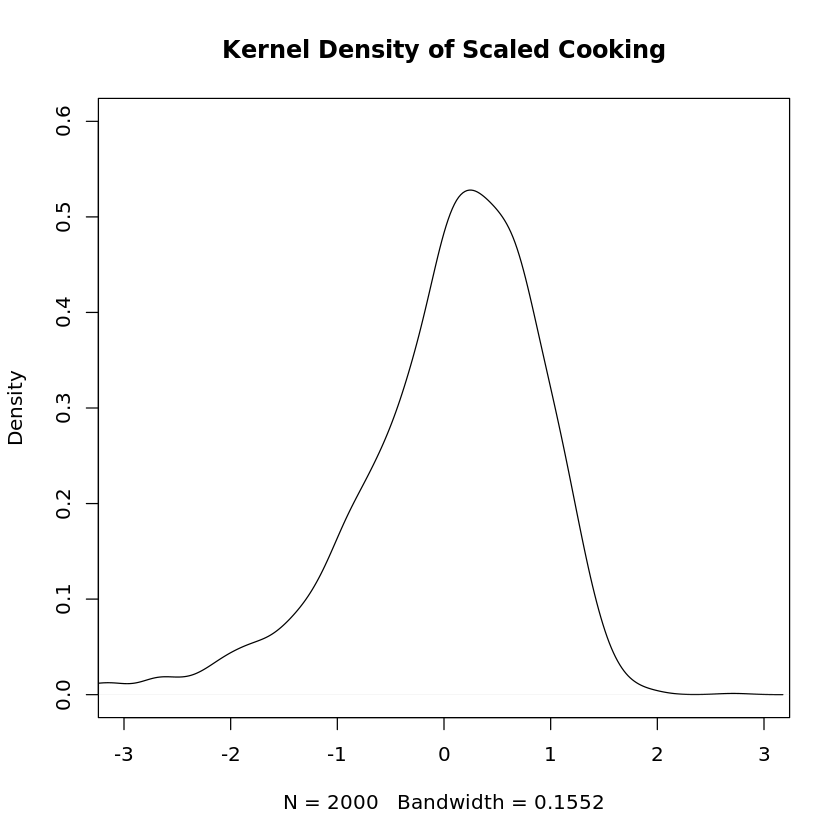

In [3]:
KROGER.SCALED <- scale_dataframe(log10(KROGER+0.01))

apply(KROGER.SCALED,2,mean); apply(KROGER.SCALED,2,sd)

hist(KROGER.SCALED$COOKING)

plot(density(KROGER.SCALED$COOKING),
     xlim=c(-3,3),ylim=c(0,0.6),
     main="Kernel Density of Scaled Cooking")

**Response:**

Since some values of KROGER are 0, we can’t take the logarithm of the original values without first adding some number to each value.

**Note:**

Although not every column looks perfectly symmetric, we're much better off than using the raw data values.

**Grading:**

2 points: 1 for showing the histogram (no points off for not doing mean/sd). 1 points for commenting on why it was necessary to add the 0.1 before logging.

# 3. K-means

Let's try k-means clustering.  Produce the "elbow plot" exploring values of `k` from 1 to 20 taking `iter.max=30` and `nstart=25`.

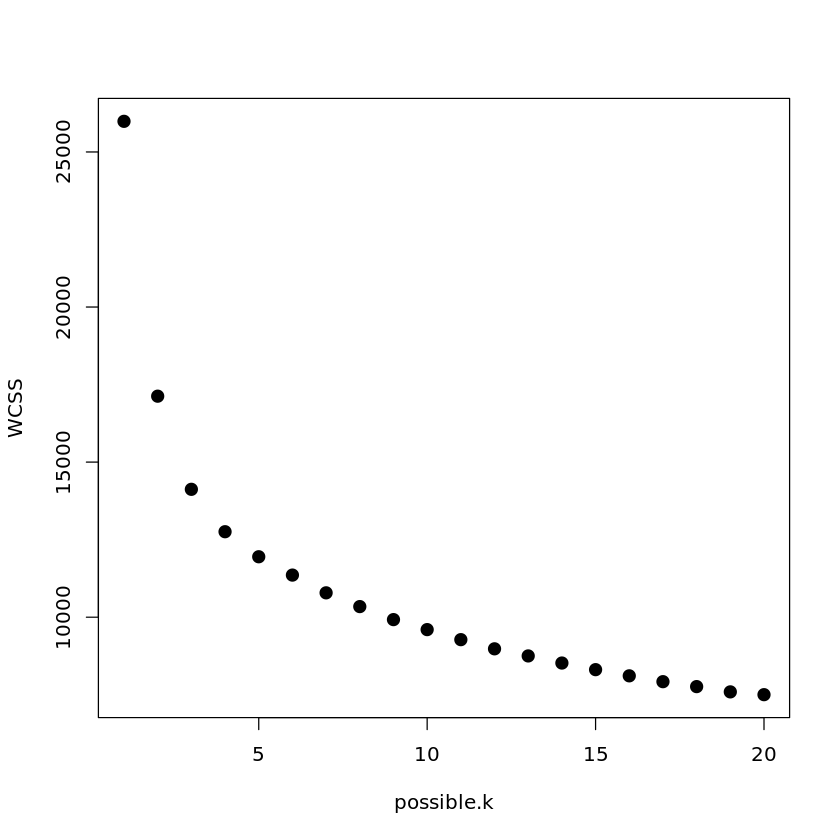

In [4]:
possible.k <- 1:20
WCSS <- c()  #Initialize a vector to store the within-cluster sum of squares for each value of k
for( k in possible.k ) {   
  WCSS[k] <- kmeans(KROGER.SCALED,center=k,iter.max=30,nstart=25)$tot.withinss 
}
plot(WCSS~possible.k,pch=20,cex=2)

a)  What does the `iter.max` parameter control about the algorithm?

**Response:**

The maximum number of cluster ID reassignments/cluster center recalculations allowed before algorithm stops (it may, and usually does, “reach convergence” early).

b)  What does the `nstart` parameter control about the algorithm and why is this parameter even necessary?

**Response:**

The number of times that the algorithm is run for a particular value of k, each using a different set of randomly picked cluster centers. It’s necessary to have this parameter because the cluster centers/IDs will typically be different if it starts with a different set of randomly picked cluster centers. The best (lowest WCSS) of the nstart attempts is chosen as the final clustering scheme.

c)  In a sentence (and without getting into technicalities), what is the `WCSS` trying to measure about the clustering scheme?

**Response:**

How tightly packed individuals are around their cluster centers (technically, the number represents how “loosely” clusters are packed, since smaller numbers are preferable). One way to interpret the WCSS is “the typical distance between individuals in a cluster and their cluster center”.

**Grading:**
3 pts total: 1 pts for original elbow plot, 0.5 points for comment about iter.max, 0.5 points for comment about nstart, 1 points for WCSS.

# 4. Three clusters

Since there is no natural choice for the number of clusters here, let's choose k=3.  Run `kmeans` on `KROGER.SCALED` with `centers=3`, `iter.max=30`, and `nstart=25`, left-arrowing the results in `KMEANS`.

a.  Print to the screen the contents of `round(KMEANS$centers,digits=2)` to see the locations of the cluster centers and `table(KMEANS$cluster)` to get a frequency table of how many individuals are in each cluster.   Note:  the labels 1/2/3 of the cluster identities may change every time you run `kmeans`, but you should always end up with the same values for the cluster centers.

In [5]:
KMEANS <- kmeans(KROGER.SCALED,center=3,iter.max=30,nstart=25)
round(KMEANS$centers,digits=2)
table(KMEANS$cluster) 

,ALCOHOL,BABY,COOKING,DRINKS,FRUITVEG,GRAIN,HEALTH,HOUSEHOLD,MEAT,OTHER,PET,PREPARED,SNACKS
1,-0.26,-0.34,-0.28,-0.35,-0.22,-0.26,-0.25,-0.26,-0.23,-0.27,-0.32,-0.28,-0.33
2,0.45,0.43,0.66,0.69,0.59,0.63,0.55,0.62,0.58,0.60,0.47,0.65,0.67
3,-1.04,-0.57,-1.97,-1.74,-1.86,-1.89,-1.55,-1.81,-1.81,-1.73,-0.85,-1.86,-1.77



  1   2   3 
868 938 194 

b.  Kroger is interested in using the cluster identities to aid in identifying segments where customized offers could be designed (e.g., people who cook, people with pets, people with babies, etc.).  While the clustering scheme you just found is valid from a technical, algorithmic point of view, the end result is not very interesting, and definitely not useful for Kroger's application.  Determine how the each cluster differs from each other, then explain why Kroger would not find this clustering scheme useful.  *This is by far the most important question on this homework.*

**Response:**

The cluster-defining characteristic is just the overall amount that the shoppers are spending at Kroger.
The three clusters can be described as “spends well-above average on all products”, “spends close to average on all products”, and “spends much below the average on all products”. This clustering scheme is great for segmenting into low/medium/high value customers, but it doesn’t allow us to do what Kroger wants, which is to target advertising to specific customer types (cooks, people with babies, people with pets, etc.).

**Grading:**

3 pts total: 0.5 points for cluster centers, 0.5 points for frequency table; 2 points for talking about why this clustering scheme is useless for the desired application. They really need to get this question, so this is all or nothing (all points if pretty much got it except the wording is awkward, no points if they’re pretty far off).

# 5. Spending fractions

For targeted advertising, it probably makes more sense to cluster on the *fraction* of the total money spent by the customer on each of the categories (instead of the raw amount).  If we find a segment that spends a much larger fraction of their shopping budget on baby items, we can target them with baby-specific promotions, etc.

Copy `KROGER` (whose contents shouldn't have been modified since the data was read in) into a data frame called `FRACTION`.
Then, write a `for` loop that defines the values in row `i` of `FRACTION` to be the fractional amounts of the values in the `i`th row of `KROGER`.
For example if `x` is a vector of the 13 dollar amounts, then `x/sum(x)` would be a vector giving these 13 fractional amounts.

Verify that the sum of each row of `FRACTION` is 1 (i.e., print to the screen the result of running `summary(apply(FRACTION,1,sum))` or `summary(rowSums(FRACTION))`, which translated into English means "summarize the row totals of each row of the `FRACTION` dataframe").

Then NULL out the `OTHER` column from `FRACTION` (one of the 13 columns is now redundant since the values in a row add to 1, so might as well get rid of the least interesting one), then left-arrow `scale_dataframe( log10(FRACTION+0.01) )` into `FRACTION.SCALED` and provide a summary of `FRACTION.SCALED$COOKING`.

In [6]:
FRACTION <- KROGER
for (n in 1:nrow(FRACTION)) {
    FRACTION[n,]<- FRACTION[n,] / sum(FRACTION[n,])
}
#FRACTION <- as.data.frame( diag(1/rowSums(FRACTION)) %*% as.matrix(FRACTION) )

summary(apply(FRACTION,1,sum))
#summary(rowSums(FRACTION))

FRACTION$OTHER <- NULL

FRACTION.SCALED <- scale_dataframe( log10(FRACTION+0.01) )

#Sanity check for number of columns of FRACTION.SCALED to make sure OTHER is nulled out
dim(FRACTION.SCALED)
#2000   12

#Sanity check for summary of COOKING column of FRACTION.SCALED
summary(FRACTION.SCALED$COOKING)
#   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.
#-4.4567 -0.4174  0.1612  0.0000  0.6063  3.3074

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1       1       1       1       1       1 

[1] 2000   12

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-4.4567 -0.4174  0.1612  0.0000  0.6063  3.3074 

**Grading:** 2pts: 1 for showing apply is all 1s; 1 for summary of COOKING column

# 6. Hierarchical clustering

Instead of running `kmeans` to get clusters, let's try hierarchical clustering this time.
Run `hclust` with arguments `dist(FRACTION.SCALED)` and `method="ward.D2"` (my favorite way of measuring distance between clusters).
Provide a plot of the dendrogram.

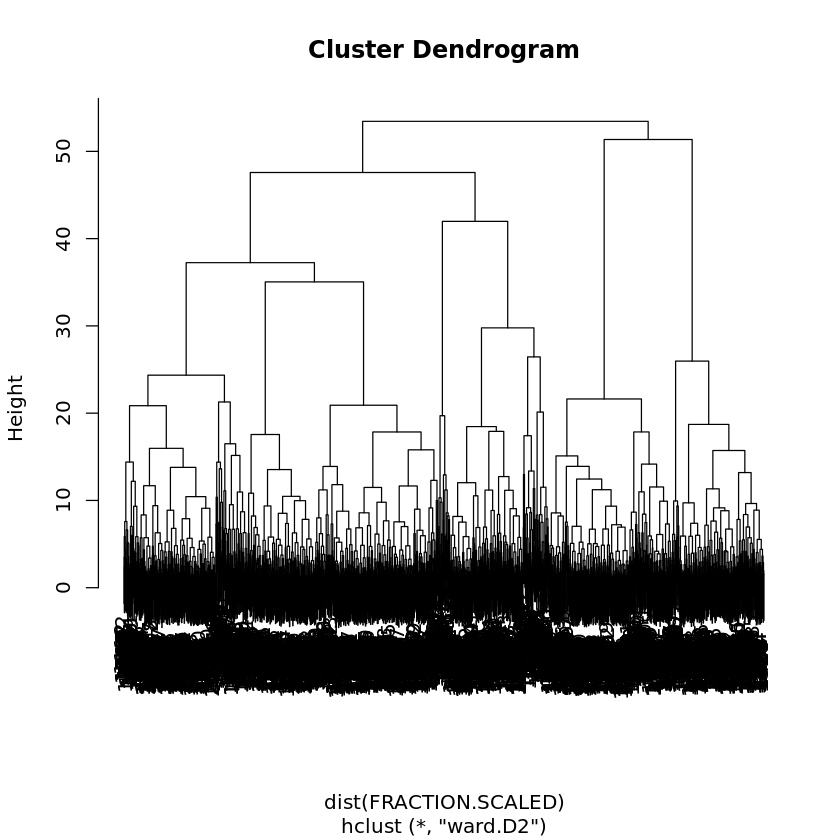

In [7]:
HC <- hclust(dist(FRACTION.SCALED), method="ward.D2")
plot(HC)

**Grading:** 2 pts. Please give 1 bonus point for any interesting explanations.

# 7. Number of clusters

There's no extremely long uninterrupted set of vertical lines, so there's no obvious, natural choice for the number of clusters that reflects underlying structure.  When this is the case, we choose a small value for the number of clusters and interpret them.  Then, we add a cluster and see if the new cluster adds to our understanding of the problem, etc.

Left-arrow `FRACTION.SCALED` into `FRACTION.SCALED.WITH.ID` and add columns `k3`, `k4`, and `k5` to it which contain the cluster identities (found from `cutree`) when 3, 4, or 5 clusters are found.

Using `aggregate`, find the average value of each column in `FRACTION.SCALED.WITH.ID` broken down by `k3`, again but broken down by `k4`, and again broken down by `k5` (e.g. `aggregate(.~k3,data=FRACTION.SCALED.WITH.ID,FUN=mean)`, etc.).  Put the `aggregate` command inside a `round()` function and print these averages to the screen to 2 digits.

In [8]:
FRACTION.SCALED.WITH.ID <- FRACTION.SCALED

FRACTION.SCALED.WITH.ID$k3 <- cutree(HC,k=3)
FRACTION.SCALED.WITH.ID$k4 <- cutree(HC,k=4)
FRACTION.SCALED.WITH.ID$k5 <- cutree(HC,k=5)

round( aggregate(.~k3,data=FRACTION.SCALED.WITH.ID,FUN=mean), digits=2 )
round( aggregate(.~k4,data=FRACTION.SCALED.WITH.ID,FUN=mean), digits=2 )
round( aggregate(.~k5,data=FRACTION.SCALED.WITH.ID,FUN=mean), digits=2 )

#Sanity check:  one row you'll see when breaking it down by k3
#  k3 ALCOHOL  BABY COOKING DRINKS FRUITVEG GRAIN HEALTH HOUSEHOLD  MEAT   PET PREPARED SNACKS   k4   k5
#1  1    0.08 -0.35   -0.14   0.04    -0.10 -0.01   0.27      0.23 -0.18  0.17    -0.04   0.12 1.52 1.55

k3,ALCOHOL,BABY,COOKING,DRINKS,FRUITVEG,GRAIN,HEALTH,HOUSEHOLD,MEAT,PET,PREPARED,SNACKS,k4,k5
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.08,-0.35,-0.14,0.04,-0.10,-0.01,0.27,0.23,-0.18,0.17,-0.04,0.12,1.52,1.55
2,-0.15,-0.31,0.53,-0.08,0.45,0.10,-0.89,-0.75,0.68,-0.46,0.15,-0.29,2.00,2.00
3,-0.15,2.02,-0.03,-0.09,-0.14,-0.09,-0.05,-0.05,-0.05,-0.16,-0.02,-0.18,4.00,5.00


k4,ALCOHOL,BABY,COOKING,DRINKS,FRUITVEG,GRAIN,HEALTH,HOUSEHOLD,MEAT,PET,PREPARED,SNACKS,k3,k5
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.28,-0.35,0.02,0.13,-0.01,0.20,0.25,0.21,-0.14,0.21,0.16,0.33,1,1.0
2,-0.15,-0.31,0.53,-0.08,0.45,0.10,-0.89,-0.75,0.68,-0.46,0.15,-0.29,2,2.0
3,1.09,-0.35,-0.61,-0.21,-0.35,-0.59,0.33,0.26,-0.31,0.04,-0.61,-0.46,1,3.1
4,-0.15,2.02,-0.03,-0.09,-0.14,-0.09,-0.05,-0.05,-0.05,-0.16,-0.02,-0.18,3,5.0


k5,ALCOHOL,BABY,COOKING,DRINKS,FRUITVEG,GRAIN,HEALTH,HOUSEHOLD,MEAT,PET,PREPARED,SNACKS,k3,k4
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.28,-0.35,0.02,0.13,-0.01,0.20,0.25,0.21,-0.14,0.21,0.16,0.33,1,1
2,-0.15,-0.31,0.53,-0.08,0.45,0.10,-0.89,-0.75,0.68,-0.46,0.15,-0.29,2,2
3,1.26,-0.38,-0.45,-0.46,-0.18,-0.51,0.40,0.45,-0.07,0.11,-0.42,-0.50,1,3
4,-0.30,-0.07,-1.93,1.94,-1.83,-1.28,-0.34,-1.41,-2.37,-0.60,-2.29,-0.10,1,3
5,-0.15,2.02,-0.03,-0.09,-0.14,-0.09,-0.05,-0.05,-0.05,-0.16,-0.02,-0.18,3,4


**Grading:** 2 points. 1 point for creating data frames, 0.5 for each aggregation, up to 2 points.

# 8. Interpretation

Looking at the centers for the three-cluster scheme, the only obvious cluster-defining characteristic is `BABY` (cluster 3 has a value of 2.02, wow!), though it's clear clusters 1 and 2 are distinct groups since the signs of almost all columns are opposite.  Look at the centers for the four-cluster scheme.  Identify which cluster (1, 2, or 3) has been "split in two", and comment on whether our understanding of the households increases when going from 3 to 4 clusters.  At this point, we'd try out 5 clusters, characterize the new clusters that emerged, determine if they are useful, etc., but you don't have to write anything for this here.

**Response:**

Cluster 1 got split in two and is now clusters 1/3 (old cluster 2 stays as cluster 2; old cluster 3 is now cluster 4). Our understanding increases, because now cluster 3 has the cluster-defining characteristic of well-above average fractions of alcohol.

**Grading:**

2 points. 1 for identifying which cluster got split in 2. 1 for some comment about how our understanding has increased since one of the clusters that emerged has an interesting new property.

# 9. Five clusters

Kroger finds the five cluster scheme to be most interesting and useful.
Characterize each of the 5 clusters with a short, meaningful description (e.g., fast-food junkies who spend most of their money on snacks and prepared food).

Clusters 1 and 2 don't have any obvious single-variable defining characteristics (nothing less than -1 or greater than 1).
Cluster 1 looks like your "average" shopper (about average in every category).
For Cluster 2, look for patterns across variables for what set of variables are "a bit above average" and "a bit below average" and tell a story.

In tandem to interpreting the output from (7), also left-arrow `KROGER` into `KROGER.HC`, then add the cluster identities in the 5 cluster scheme in a column named `k5`, then use `aggregate` to look at the median value for each category, rounded to the nearest dollar.

In [9]:
KROGER.HC <- KROGER
KROGER.HC$k5 <- cutree(HC,k=5)
round( aggregate(.~k5,data=KROGER.HC,FUN=median) )

k5,ALCOHOL,BABY,COOKING,DRINKS,FRUITVEG,GRAIN,HEALTH,HOUSEHOLD,MEAT,OTHER,PET,PREPARED,SNACKS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,16,0,316,393,218,103,107,142,314,135,12,454,282
2,20,0,379,321,276,94,24,54,574,85,0,419,175
3,154,0,221,233,184,63,104,135,321,128,4,304,125
4,0,0,20,237,10,7,13,6,4,18,0,20,44
5,28,350,452,488,240,133,106,146,486,180,9,557,268


**Response:**

* Cluster 1 - "average shopper" (no real cluster-defining characteristics)
* Cluster 2 - Cooks (only group with above average COOKING, FRUITVEG, MEAT, though you'll see above median amounts in cluster 5 for cooking)
* Cluster 3 - alcoholic drinkers (1.26 in ALCOHOL)
* Cluster 4 - non-alcoholic drinkers (pretty much only buy DRINKS, well-below everything else)
* Cluster 5 - Baby owners (2.02 in BABY)

**Grading:**

2 points.
This is kind of a tough one so I’m ok with being somewhat lenient, though I think the descriptions above are pretty accurate.